 After your finish the assignment, remember to run all cells and save the note book to your local machine as a PDF for gradescope submission by pressing Ctrl-P or Cmd-P. Make sure images are not split between pages; insert Text blocks to make sure this is the case before printing to PDF!

List your collaborators here:



---



# **16720 HW 4: 3D Reconstruction**

# Problem 1: Theory

## 1.1
See pdf for the question.




# ===== your answer here for 1.1! =====
Since $x$ and $x'$ are the homogeneous coordinates of corresponding points in the left and right images respectively, the fundamental matrix $x'^TFx=0$. \\

Given that $x=x'=\begin{bmatrix}0 & 0 & 1\end{bmatrix}^T$, the matrix $x'^TFx$ can be expanded as: \\

$x'^TFx=\begin{bmatrix}0 \\ 0 \\ 1\end{bmatrix}\begin{bmatrix}f_{11} & f_{12} & f_{13} \\ f_{21} & f_{22} & f_{23} \\ f_{31} & f_{32} & f_{33}\end{bmatrix}\begin{bmatrix}0 \\ 0 \\ 1\end{bmatrix}=\begin{bmatrix}0 \\ 0 \\ 1\end{bmatrix}\begin{bmatrix}f_{13} \\ f_{23} \\ f_{33}\end{bmatrix}=f_{33}$ \\

Since $x'^TFx=0$, $f_{33}$ must be zero.
# ===== end of your answer for 1.1 =====

##1.2
See pdf for the question.

# ===== your answer here for 1.2! =====
$R_{rel}=R_i^{-1}R_{i+1}$ \\

$R_{rel}=R_i^{-1}(t_{i+1}-t_i)$
# ===== end of your answer for 1.2 =====

# **Coding**

## **Initialization**

Run the following code, which imports the modules you'll need and defines helper functions you may need to use later in your implementations.

In [ ]:
import os
import numpy as np
import scipy
import scipy.optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab.patches import cv2_imshow
import cv2
import math


connections_3d = [[0,1], [1,3], [2,3], [2,0], [4,5], [6,7], [8,9], [9,11], [10,11], [10,8], [0,4], [4,8],
                  [1,5], [5,9], [2,6], [6,10], [3,7], [7,11]]
color_links = [(255,0,0),(255,0,0),(255,0,0),(255,0,0),(0,0,255),(255,0,255),(0,255,0),(0,255,0),(0,255,0),(0,255,0),(0,0,255),(0,0,255),(0,0,255),(0,0,255),(255,0,255),(255,0,255),(255,0,255),(255,0,255)]
colors = ['blue','blue','blue','blue','red','magenta','green','green','green','green','red','red','red','red','magenta','magenta','magenta','magenta']


def visualize_keypoints(image, pts, Threshold=100):
    '''
    This function visualizes the 2d keypoint pairs in connections_3d
    (as define above) whose match score lies above a given Threshold
    in an OpenCV GUI frame, against an image background.

    :param image: image as a numpy array, of shape (height, width, 3) where 3 is the number of color channels
    :param pts: np.array of shape (num_points, 3)
    '''
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i in range(12):
        cx, cy = pts[i][0:2]
        if pts[i][2]>Threshold:
            cv2.circle(image,(int(cx),int(cy)),5,(0,255,255),5)

    for i in range(len(connections_3d)):
        idx0, idx1 = connections_3d[i]
        if pts[idx0][2]>Threshold and pts[idx1][2]>Threshold:
            x0, y0 = pts[idx0][0:2]
            x1, y1 = pts[idx1][0:2]
            cv2.line(image, (int(x0), int(y0)), (int(x1), int(y1)), color_links[i], 2)

    cv2_imshow(image)

    return image


def plot_3d_keypoint(pts_3d):
    '''
    this function visualizes 3d keypoints on a matplotlib 3d axes

    :param pts_3d: np.array of shape (num_points, 3)
    '''
    fig = plt.figure()
    num_points = pts_3d.shape[0]
    ax = fig.add_subplot(111, projection='3d')
    for j in range(len(connections_3d)):
        index0, index1 = connections_3d[j]
        xline = [pts_3d[index0,0], pts_3d[index1,0]]
        yline = [pts_3d[index0,1], pts_3d[index1,1]]
        zline = [pts_3d[index0,2], pts_3d[index1,2]]
        ax.plot(xline, yline, zline, color=colors[j])
    np.set_printoptions(threshold=1e6, suppress=True)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()


def calc_epi_error(pts1_homo, pts2_homo, F):
    '''
    Helper function to calcualte the sum of squared distance between the
    corresponding points and the estimated epipolar lines.

    pts1_homo \dot F.T \dot pts2_homo = 0

    :param pts1_homo: of shape (num_points, 3); in homogeneous coordinates, not normalized.
    :param pts2_homo: same specification as to pts1_homo.
    :param F: Fundamental matrix
    '''

    line1s = pts1_homo.dot(F.T)
    dist1 = np.square(np.divide(np.sum(np.multiply(
        line1s, pts2_homo), axis=1), np.linalg.norm(line1s[:, :2], axis=1)))

    line2s = pts2_homo.dot(F)
    dist2 = np.square(np.divide(np.sum(np.multiply(
        line2s, pts1_homo), axis=1), np.linalg.norm(line2s[:, :2], axis=1)))

    ress = (dist1 + dist2).flatten()
    return ress


def toHomogenous(pts):
    """
    Adds a stack of ones at the end, to turn a set of points into a set of
    homogeneous points.

    :params pts: in shape (num_points, 2).
    """
    return np.vstack([pts[:,0],pts[:,1],np.ones(pts.shape[0])]).T.copy()


def _epipoles(E):
    """
    gets the epipoles from the Essential Matrix.

    :params E: Essential matrix.
    """
    U, S, V = np.linalg.svd(E)
    e1 = V[-1, :]
    U, S, V = np.linalg.svd(E.T)
    e2 = V[-1, :]
    return e1, e2


def displayEpipolarF(I1, I2, F, points):
    """
    GUI interface you may use to help you verify your calculated fundamental
    matrix F. Select a point I1 in one view, and it should correctly correspond
    to the displayed point in the second view.
    """
    e1, e2 = _epipoles(F)

    sy, sx, _ = I2.shape

    f, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 9))
    ax1.imshow(I1)
    ax1.set_title('The point you selected:')
    ax2.imshow(I2)
    ax2.set_title('Verify that the corresponding point \n is on the epipolar line in this image')

    plt.sca(ax1)

    colors = ['r','g','b','y','m','k']
    for i, out in enumerate(points):
      x, y = out #[0]

      xc = x
      yc = y
      v = np.array([xc, yc, 1])
      l = F.dot(v)
      s = np.sqrt(l[0]**2+l[1]**2)

      if s==0:
          print('Zero line vector in displayEpipolar')

      l = l/s

      if l[0] != 0:
          ye = sy-1
          ys = 0
          xe = -(l[1] * ye + l[2])/l[0]
          xs = -(l[1] * ys + l[2])/l[0]
      else:
          xe = sx-1
          xs = 0
          ye = -(l[0] * xe + l[2])/l[1]
          ys = -(l[0] * xs + l[2])/l[1]

      # plt.plot(x,y, '*', 'MarkerSize', 6, 'LineWidth', 2);
      ax1.plot(x, y, '*', markersize=6, linewidth=2, color=colors[i%len(colors)])
      ax2.plot([xs, xe], [ys, ye], linewidth=2, color=colors[i%len(colors)])
    plt.draw()


def _singularize(F):
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F = U.dot(np.diag(S).dot(V))
    return F

def _objective_F(f, pts1, pts2):
    F = _singularize(f.reshape([3, 3]))
    num_points = pts1.shape[0]
    hpts1 = np.concatenate([pts1, np.ones([num_points, 1])], axis=1)
    hpts2 = np.concatenate([pts2, np.ones([num_points, 1])], axis=1)
    Fp1 = F.dot(hpts1.T)
    FTp2 = F.T.dot(hpts2.T)

    r = 0
    for fp1, fp2, hp2 in zip(Fp1.T, FTp2.T, hpts2):
        r += (hp2.dot(fp1))**2 * (1/(fp1[0]**2 + fp1[1]**2) + 1/(fp2[0]**2 + fp2[1]**2))
    return r

def refineF(F, pts1, pts2):
    f = scipy.optimize.fmin_powell(
        lambda x: _objective_F(x, pts1, pts2), F.reshape([-1]),
        maxiter=100000,
        maxfun=10000,
        disp=False
    )
    return _singularize(f.reshape([3, 3]))


# Used in 4.2 Epipolar Correspondence
def epipolarMatchGUI(I1, I2, F, points, epipolarCorrespondence):
    e1, e2 = _epipoles(F)

    sy, sx, _ = I2.shape

    f, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 9))
    ax1.imshow(I1)
    ax1.set_title('The point you selected:')
    ax2.imshow(I2)
    ax2.set_title('Verify that the corresponding point \n is on the epipolar line in this image \nand that the corresponding point matches')

    plt.sca(ax1)

    colors = ['r','g','b','y','m','k']

    for i, out in enumerate(points):
      x, y = out

      xc = int(x)
      yc = int(y)
      v = np.array([xc, yc, 1])
      l = F.dot(v)
      s = np.sqrt(l[0]**2+l[1]**2)

      if s==0:
          print('Zero line vector in displayEpipolar')

      l = l/s

      if l[0] != 0:
          ye = sy-1
          ys = 0
          xe = -(l[1] * ye + l[2])/l[0]
          xs = -(l[1] * ys + l[2])/l[0]
      else:
          xe = sx-1
          xs = 0
          ye = -(l[0] * xe + l[2])/l[1]
          ys = -(l[0] * xs + l[2])/l[1]

      ax1.plot(x, y, '*', markersize=6, linewidth=2, color=colors[i%len(colors)])
      ax2.plot([xs, xe], [ys, ye], linewidth=2, color=colors[i%len(colors)])

      # draw points
      x2, y2 = epipolarCorrespondence(I1, I2, F, xc, yc)
      ax2.plot(x2, y2, 'ro', markersize=8, linewidth=2)
      plt.draw()



## **Set up data**
In this section, we will download the test case image views, camera intrinsics, and point correnspondences, which you will use for testing your implementations.

In [ ]:
if not os.path.exists('data'):
  !wget https://www.andrew.cmu.edu/user/eweng/data.zip -O data.zip
  !unzip -qq "data.zip"
  print("downloaded and unzipped data")

--2024-03-23 22:04:05--  https://www.andrew.cmu.edu/user/eweng/data.zip
Resolving www.andrew.cmu.edu (www.andrew.cmu.edu)... 128.2.42.53
Connecting to www.andrew.cmu.edu (www.andrew.cmu.edu)|128.2.42.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21314971 (20M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  20.33M   684KB/s    in 33s     

2024-03-23 22:04:40 (627 KB/s) - ‘data.zip’ saved [21314971/21314971]

downloaded and unzipped data


# Problem 2: Estimating the Fundamental Matrix with the Eight-point Algorithm

In this part, implement the 8-point algorithm you learned in class, which estimates the fundamental matrix from corresponding points in two images.

In [ ]:
def eightpoint(pts1, pts2, M):
  '''
  Q2.1: Eight Point Algorithm
  Input:  pts1, Nx2 Matrix
          pts2, Nx2 Matrix
          M, a scalar parameter computed as max(imwidth, imheight)
  Output: F, the fundamental matrix

  HINTS:
  (1) Normalize the input pts1 and pts2 using the matrix T.
  (2) Setup the eight point algorithm's equation.
  (3) Solve for the least square solution using SVD.
  (4) Use the function `_singularize` (provided in the helper functions above) to enforce the singularity condition.
  (5) Use the function `refineF` (provided in the helper functions above) to refine the computed fundamental matrix.
      (Remember to use the normalized points instead of the original points)
  (6) Unscale the fundamental matrix by the lower right corner element
  '''


  F = None
  N = pts1.shape[0]

  # ===== your code here! =====
  x1_normal = pts1[:, 0] / M
  y1_normal = pts1[:, 1] / M
  x2_normal = pts2[:, 0] / M
  y2_normal = pts2[:, 1] / M
  T = np.array([[1/M, 0  , 0],
                [0  , 1/M, 0],
                [0  , 0  , 1]])
  A = np.vstack((x2_normal * x1_normal, x2_normal * y1_normal, x2_normal, y2_normal * x1_normal,
                 y2_normal * y1_normal, y2_normal, x1_normal, y1_normal, np.ones(x1_normal.shape))).T
  u, s, vh = np.linalg.svd(A)
  F = vh[-1, :].reshape(3, 3)
  F = _singularize(F)
  F = refineF(F, pts1 / M, pts2 / M)
  F = T.T @ F @ T
  F /= F[-1, -1]
  # ==== end of code ====

  return F

Run this code to test your implementation of the 8-point algorithm. Your code should pass all the assert statements at the end.

In [ ]:
correspondence = np.load('data/some_corresp.npz') # Loading correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1 = plt.imread('data/im1.png')
im2 = plt.imread('data/im2.png')

F = eightpoint(pts1, pts2, M=np.max([*im1.shape, *im2.shape]))
print(f'recovered F:\n{F.round(4)}')

# Simple Tests to verify your implementation:
pts1_homogenous, pts2_homogenous = toHomogenous(pts1), toHomogenous(pts2)

assert F.shape == (3, 3), "F is wrong shape"
assert F[2, 2] == 1, "F_33 != 1"
assert np.linalg.matrix_rank(F) == 2, "F should have rank 2"
assert np.mean(calc_epi_error(pts1_homogenous, pts2_homogenous, F)) < 1, "F error is too high to be accurate"

recovered F:
[[-0.      0.     -0.2519]
 [ 0.     -0.      0.0026]
 [ 0.2422 -0.0068  1.    ]]


The following tool may help you debug. You may specify a point in im1, and view the corresponding epipolar line in im2 based on the F you found. In your submission, make sure you include the debug picture below, with at least five epipolar point-line correspondences taht show that your calculation of F is correct.



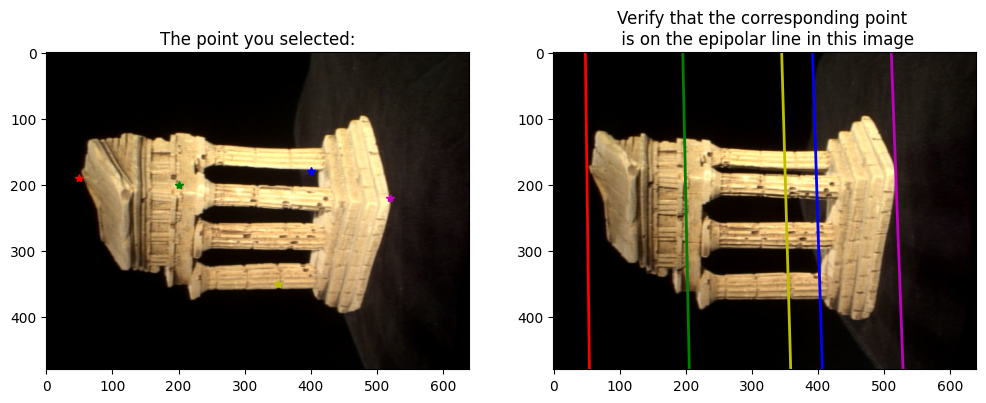

In [ ]:
# the points in im1, whose correnponding epipolar line in im2 you'd like to verify
point = [(50,190),(200, 200), (400,180), (350,350), (520, 220)]
# feel free to change these point, to verify different point correspondences
displayEpipolarF(im1, im2, F, point)

# Problem 3: Metric Reconstruction

## 3.1 Essential Matrix

In [ ]:
def essentialMatrix(F, K1, K2):
  '''
  Q3.1: Compute the essential matrix E.
    Input:  F, fundamental matrix
            K1, internal camera calibration matrix of camera 1
            K2, internal camera calibration matrix of camera 2
    Output: E, the essential matrix
  '''

  # ----- TODO -----
  ### BEGIN SOLUTION
  E = np.dot(np.dot(K2.T, F), K1)
  E /= E[2, 2]
  ### END SOLUTION
  return E

Run the following code to check your implementation.

In [ ]:
correspondence = np.load('data/some_corresp.npz') # Loading correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1 = plt.imread('data/im1.png')
im2 = plt.imread('data/im2.png')

F = eightpoint(pts1, pts2, M=np.max([*im1.shape, *im2.shape]))
E = essentialMatrix(F, K1, K2)
print(f'recovered E:\n{E.round(4)}')

# Simple Tests to verify your implementation:
assert(E[2, 2] == 1)
assert(np.linalg.matrix_rank(E) == 2)

recovered E:
[[-3.3716000e+00  4.5661580e+02 -2.4738947e+03]
 [ 1.9760420e+02 -1.0290300e+01  6.4396600e+01]
 [ 2.4807427e+03  1.9856400e+01  1.0000000e+00]]


# 3.2 Triangulation


In [ ]:
def triangulate(C1, pts1, C2, pts2):
  '''
  Q3.2: Triangulate a set of 2D coordinates in the image to a set of 3D points.
  Input:  C1, the 3x4 camera matrix
          pts1, the Nx2 matrix with the 2D image coordinates per row
          C2, the 3x4 camera matrix
          pts2, the Nx2 matrix with the 2D image coordinates per row
  Output: P, the Nx3 matrix with the corresponding 3D points per row
          err, the reprojection error.

  Hints:
  (1) For every input point, form A using the corresponding points from pts1 & pts2 and C1 & C2
  (2) Solve for the least square solution using np.linalg.svd
  (3) Calculate the reprojection error using the calculated 3D points and C1 & C2 (do not forget to convert from
      homogeneous coordinates to non-homogeneous ones)
  (4) Keep track of the 3D points and projection error, and continue to next point
  (5) You do not need to follow the exact procedure above.
  '''

  # ----- TODO -----
  ### BEGIN SOLUTION
  x1= pts1[:, 0]
  y1= pts1[:, 1]
  x2= pts2[:, 0]
  y2= pts2[:, 1]
  A1 = np.vstack((C1[0, 0] - C1[2, 0] * x1, C1[0, 1] - C1[2, 1] * x1,
                  C1[0, 2] - C1[2, 2] * x1, C1[0, 3] - C1[2, 3] * x1)).T
  A2 = np.vstack((C1[1, 0] - C1[2, 0] * y1, C1[1, 1] - C1[2, 1] * y1,
                  C1[1, 2] - C1[2, 2] * y1, C1[1, 3] - C1[2, 3] * y1)).T
  A3 = np.vstack((C2[0, 0] - C2[2, 0] * x2, C2[0, 1] - C2[2, 1] * x2,
                  C2[0, 2] - C2[2, 2] * x2, C2[0, 3] - C2[2, 3] * x2)).T
  A4 = np.vstack((C2[1, 0] - C2[2, 0] * y2, C2[1, 1] - C2[2, 1] * y2,
                  C2[1, 2] - C2[2, 2] * y2, C2[1, 3] - C2[2, 3] * y2)).T
  P = np.zeros((pts1.shape[0], 3))
  for i in range(pts1.shape[0]):
        A = np.vstack((A1[i, :], A2[i, :], A3[i, :], A4[i, :]))
        u, s, vh = np.linalg.svd(A)
        P[i, :] = vh[-1, :3] / vh[-1, -1]
  err = 0

  W = np.hstack((P, np.ones((pts1.shape[0], 1))))
  for i in range(pts1.shape[0]):
        projection1 = np.dot(C1, W[i, :].T)
        projection2 = np.dot(C2, W[i, :].T)
        projection1 = (projection1[:2] / projection1[-1]).T
        projection2 = (projection2[:2] / projection2[-1]).T
        err += np.sum(np.square(projection1 - pts1[i]) + np.square(projection2 - pts2[i]))
  ### END SOLUTION

  return P, err

## 3.3 Find M2

In [ ]:
def camera2(E):
  """helper function to find the 4 possibile M2 matrices"""
  U,S,V = np.linalg.svd(E)
  m = S[:2].mean()
  E = U.dot(np.array([[m,0,0], [0,m,0], [0,0,0]])).dot(V)
  U,S,V = np.linalg.svd(E)
  W = np.array([[0,-1,0], [1,0,0], [0,0,1]])

  if np.linalg.det(U.dot(W).dot(V))<0:
      W = -W

  M2s = np.zeros([3,4,4])
  M2s[:,:,0] = np.concatenate([U.dot(W).dot(V), U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
  M2s[:,:,1] = np.concatenate([U.dot(W).dot(V), -U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
  M2s[:,:,2] = np.concatenate([U.dot(W.T).dot(V), U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
  M2s[:,:,3] = np.concatenate([U.dot(W.T).dot(V), -U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
  return M2s


def findM2(F, pts1, pts2, intrinsics):
    '''
    Q3.3: Function to find camera2's projective matrix given correspondences
        Input:  F, the pre-computed fundamental matrix
                pts1, the Nx2 matrix with the 2D image coordinates per row
                pts2, the Nx2 matrix with the 2D image coordinates per row
                intrinsics, the intrinsics of the cameras, load from the .npz file
                filename, the filename to store results
        Output: [M2, C2, P] the computed M2 (3x4) camera projective matrix, C2 (3x4) K2 * M2, and the 3D points P (Nx3)

    ***
    Hints:
    (1) Loop through the 'M2s' and use triangulate to calculate the 3D points and projection error. Keep track
        of the projection error through best_error and retain the best one.
    (2) Remember to take a look at camera2 to see how to correctly reterive the M2 matrix from 'M2s'.

    '''

    K1, K2 = intrinsics['K1'], intrinsics['K2']

    # ----- TODO -----
    ### BEGIN SOLUTION
    E = essentialMatrix(F, K1, K2)
    M2s = camera2(E)

    M1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
    C1 = np.dot(K1, M1)

    for i in range(M2s.shape[-1]):
    	M2 = M2s[:, :, i]
    	C2 = np.dot(K2, M2)
    	P, err = triangulate(C1, pts1, C2, pts2)
    	if np.min(P[:, -1]) > 0:
    		break
    C2 = np.dot(K2, M2)
    print(err)
    ### END SOLUTION

    return M2, C2, P

Run the following code to check your implementation of triangulation and findM2.

In [ ]:
correspondence = np.load('data/some_corresp.npz') # Loading correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1 = plt.imread('data/im1.png')
im2 = plt.imread('data/im2.png')

F = eightpoint(pts1, pts2, M=np.max([*im1.shape, *im2.shape]))

M2, C2, P = findM2(F, pts1, pts2, intrinsics)

# Simple Tests to verify your implementation:
M1 = np.hstack((np.identity(3), np.zeros(3)[:,np.newaxis]))
C1 = K1.dot(M1)
C2 = K2.dot(M2)
P_test, err = triangulate(C1, pts1, C2, pts2)
assert(err < 500)

351.8979664905338


# Problem 4: 3D Visualization

In [ ]:
def epipolarCorrespondence(im1, im2, F, x1, y1):
  '''
  Q4.1: 3D visualization of the temple images.
  Input:  im1, the first image
          im2, the second image
          F, the fundamental matrix
          x1, x-coordinates of a pixel on im1
          y1, y-coordinates of a pixel on im1
  Output: x2, x-coordinates of the pixel on im2
          y2, y-coordinates of the pixel on im2

  Hints:
  (1) Given input [x1, x2], use the fundamental matrix to recover the corresponding epipolar line on image2
  (2) Search along this line to check nearby pixel intensity (you can define a search window) to
      find the best matches
  (3) Use gaussian weighting to weight the pixel simlairty

  '''
  # ----- TODO -----
  # YOUR CODE HERE
  # weight = np.exp(-(x**2 + y**2) / (2.0 * sigma**2))
  # # weight /= np.sum(weight)
  # # weight = np.repeat(weight[:, :, None], im1.shape[-1], axis = 2)

  # min_error = float("inf")
  # x2, y2 = None, None
  # for i in range(len(X)):
  #     patch = im2[Y[i] -window_size // 2 : Y[i] + window_size // 2 + 1,
  #                 X[i] - window_size // 2 : X[i] + window_size // 2 + 1]
  #     error = np.sum(np.abs(template - patch) * weight[..., None], axis=(0, 1))
  #     if error < min_error:
  #         min_error = error
  #         x2, y2 = X[i], Y[i]
  window_size = 20
  sigma = 5
  half_window = window_size // 2

  y1 = np.clip(y1, half_window, im1.shape[0] - half_window - 1)
  x1 = np.clip(x1, half_window, im1.shape[1] - half_window - 1)

  template = im1[y1 - half_window:y1 + half_window + 1,
                 x1 - half_window:x1 + half_window + 1].astype(np.float32)

  p = np.array([x1, y1, 1])
  ep_line = np.dot(F, p)

  Y = np.arange(half_window, im2.shape[0] - half_window)
  X = np.round(-(ep_line[1] * Y + ep_line[2]) / ep_line[0]).astype(int)

  valid_coords = (X >= half_window) & (X < im2.shape[1] - half_window)
  X, Y = X[valid_coords], Y[valid_coords]

  offset = np.arange(-half_window, half_window + 1)
  gx, gy = np.meshgrid(offset, offset)
  weight = np.exp(-(gx**2 + gy**2) / (2.0 * sigma**2))
  weight /= np.sum(weight)
  weight = weight[:, :, np.newaxis]
  min_error = float('inf')
  x2, y2 = None, None

  for x, y in zip(X, Y):
    patch = im2[y - half_window:y + half_window + 1,
                          x - half_window:x + half_window + 1].astype(np.float32)
    error = np.sum(weight * np.abs(template - patch))
    if error < min_error:
        min_error = error
        x2, y2 = x, y

  return x2, y2

  # END YOUR CODE
  return x2, y2

Run the following code to check your implementation.

In [ ]:
correspondence = np.load('data/some_corresp.npz') # Loading correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1 = plt.imread('data/im1.png')
im2 = plt.imread('data/im2.png')

F = eightpoint(pts1, pts2, M=np.max([*im1.shape, *im2.shape]))

# Simple Tests to verify your implementation:
x2, y2 = epipolarCorrespondence(im1, im2, F, 119, 217)
assert(np.linalg.norm(np.array([x2, y2]) - np.array([118, 181])) < 10)

Use the below tool to debug your code.

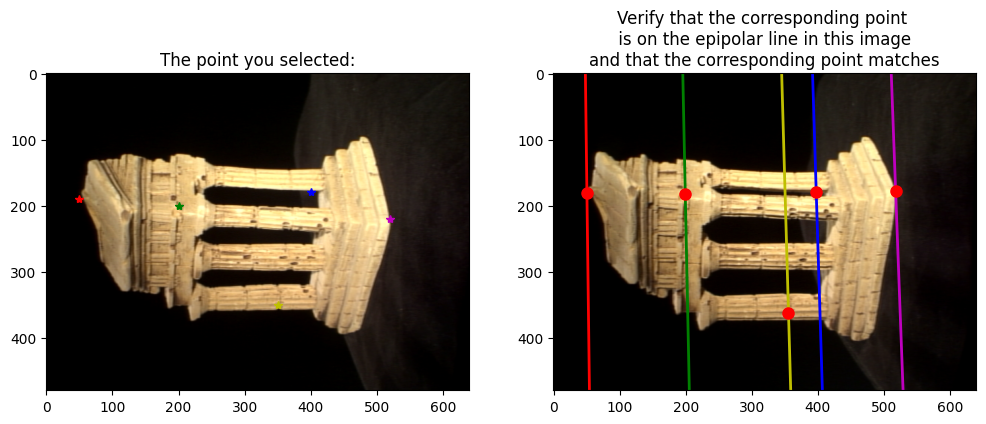

In [ ]:
# the points in im1 whose correnponding epipolar line in im2 you'd like to verify
points = [(50,190), (200, 200), (400,180), (350,350), (520, 220)]
# feel free to change these points to verify different point correspondences
epipolarMatchGUI(im1, im2, F, points, epipolarCorrespondence)

##4.2 Temple Visualization

In [ ]:
def compute3D_pts(temple_pts1, intrinsics, F, im1, im2):
  '''
  Q4.2: Finding the 3D position of given points based on epipolar correspondence and triangulation
  Input:  temple_pts1, chosen points from im1
          intrinsics, the intrinsics dictionary for calling epipolarCorrespondence
          F, the fundamental matrix
          im1, the first image
          im2, the second image
  Output: P (Nx3) the recovered 3D points

  Hints:
  (1) Use epipolarCorrespondence to find the corresponding point for [x1 y1] (find [x2, y2])
  (2) Now you have a set of corresponding points [x1, y1] and [x2, y2], you can compute the M2
      matrix and use triangulate to find the 3D points.
  (3) Use the function findM2 to find the 3D points P (do not recalculate fundamental matrices)
  (4) As a reference, our solution's best error is around ~2200 on the 3D points.
  '''
  # ----- TODO -----
  # YOUR CODE HERE
  x2, y2 = [], []
  for i in range(temple_pts1.shape[0]):
    coor = epipolarCorrespondence(im1, im2, F, temple_pts1[i][0], temple_pts1[i][1])
    x2.append(coor[0])
    y2.append(coor[1])
  x2 = np.array(x2).reshape(-1, 1)
  y2 = np.array(y2).reshape(-1, 1)
  pts2 = np.hstack([x2, y2])
  M2, C2, P = findM2(F, temple_pts1, pts2, intrinsics)
  return P
  # END YOUR CODE

Below, integrate everything together.
The provided starter code loads in the temple data found at `data/templeCoords.npz`, which contains 288 hand-selected points from im1 saved in the variables x1 and y1.
Then, get the 3d points from the 2d point point correspondences by calling the function you just implemented, as well as other necessary function. Finally, visualize the 3D reconstruction using matplotlib or plotly 3d scatter plot.


723.042357544585


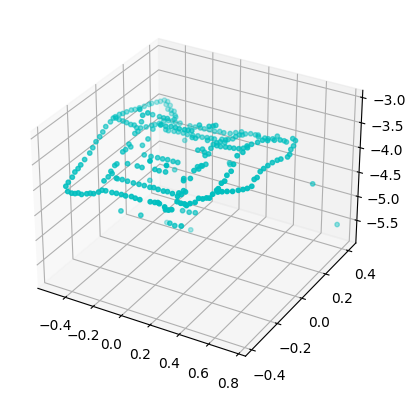

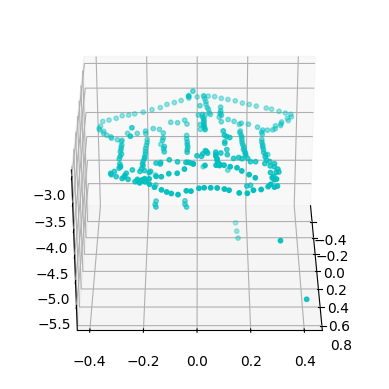

In [ ]:
temple_coords = np.load('data/templeCoords.npz') # Loading temple coordinates
correspondence = np.load('data/some_corresp.npz') # Loading correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1 = plt.imread('data/im1.png')
im2 = plt.imread('data/im2.png')

# ----- TODO -----
# Call eightpoint to get the F matrix
# Call compute3D_pts to get the 3D points and visualize using matplotlib scatter
# hint: you can change the viewpoint of a matplotlib 3d axes using
# `ax.view_init(azim, elev)` where azim is the rotation around the vertical z
# axis, and elev is the angle of elevation from the x-y plane

temple_pts1 = np.hstack([temple_coords['x1'], temple_coords['y1']])

# YOUR CODE HERE
M = np.max(im1.shape)
F = eightpoint(pts1, pts2, M)
P = compute3D_pts(temple_pts1, intrinsics, F, im1, im2)
P = 0 - P
# END YOUR CODE

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(P[:, 0], P[:, 1], P[:, 2], s=10, c='c', depthshade=True)
plt.draw()

# also show a different viewpoint
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(P[:, 0], P[:, 1], P[:, 2], s=10, c='c', depthshade=True)
ax.view_init(30, 0)
plt.draw()


# Problem 5: Bundle Adjustment

Below is the implementation of RANSAC for Fundamental Matrix Recovery.

In [ ]:
def ransacF(pts1, pts2, M, nIters=100, tol=10):
  '''
  Input:  pts1, Nx2 Matrix
          pts2, Nx2 Matrix
          M, a scaler parameter
          nIters, Number of iterations of the Ransac
          tol, tolerence for inliers
  Output: F, the fundamental matrix
          inliers, Nx1 bool vector set to true for inliers

  '''
  N = pts1.shape[0]
  pts1_homo, pts2_homo = toHomogenous(pts1), toHomogenous(pts2)
  best_inlier = 0
  inlier_curr = None

  for i in range(nIters):
      choice = np.random.choice(range(pts1.shape[0]), 8)
      pts1_choice = pts1[choice, :]
      pts2_choice = pts2[choice, :]
      F = eightpoint(pts1_choice, pts2_choice, M)
      ress = calc_epi_error(pts1_homo, pts2_homo, F)
      curr_num_inliner = np.sum(ress < tol)
      if curr_num_inliner > best_inlier:
          F_curr = F
          inlier_curr = (ress < tol)
          best_inlier = curr_num_inliner
  inlier_curr = inlier_curr.reshape(inlier_curr.shape[0], 1)
  indixing_array = inlier_curr.flatten()
  pts1_inlier = pts1[indixing_array]
  pts2_inlier = pts2[indixing_array]
  F = eightpoint(pts1_inlier, pts2_inlier, M)
  return F, inlier_curr

Below is the implementation of Rodrigues and Inverse Rodrigues Formulas. See the pdf for the detailed explanation of the functions.

In [ ]:
def rodrigues(r):
  '''
      Input:  r, a 3x1 vector
      Output: R, a rotation matrix
  '''

  r = np.array(r).flatten()
  I = np.eye(3)
  theta = np.linalg.norm(r)
  if theta == 0:
      return I
  else:
      U = (r/theta)[:, np.newaxis]
      Ux, Uy, Uz = r/theta
      K = np.array([[0, -Uz, Uy], [Uz, 0, -Ux], [-Uy, Ux, 0]])
      R = I * np.cos(theta) + np.sin(theta) * K + \
          (1 - np.cos(theta)) * np.matmul(U, U.T)
  return R


def invRodrigues(R):
  '''
  Input:  R, a rotation matrix
  Output: r, a 3x1 vector
  '''

  def s_half(r):
      r1, r2, r3 = r
      if np.linalg.norm(r) == np.pi and (r1 == r2 and r1 == 0 and r2 == 0 and r3 < 0) or (r1 == 0 and r2 < 0) or (r1 < 0):
          return -r
      else:
          return r

  A = (R - R.T)/2
  ro = [A[2, 1], A[0, 2], A[1, 0]]
  s = np.linalg.norm(ro)
  c = (np.sum(np.matrix(R).diagonal()) - 1)/2
  if s == 0 and c == 1:
      r = np.zeros(3)
  elif s == 0 and c == -1:
      col = np.eye(3) + R
      col_idx = np.nonzero(
          np.array(np.sum(col != 0, axis=0)).flatten())[0][0]
      v = col[:, col_idx]
      u = v/np.linalg.norm(v)
      r = s_half(u * np.pi)
  else:
      u = ro/s
      theta = np.arctan2(s, c)
      r = u * theta

  return r

### Rodrigues Residual objective function




In [ ]:
def rodriguesResidual(K1, M1, p1, K2, p2, x):
  '''
  Q5.1: Rodrigues residual.
    Input:  K1, the intrinsics of camera 1
            M1, the extrinsics of camera 1
            p1, the 2D coordinates of points in image 1
            K2, the intrinsics of camera 2
            p2, the 2D coordinates of points in image 2
            x, the flattened concatenationg of P, r2, and t2.
    Output: residuals, 4N x 1 vector, the difference between original and estimated projections
  '''
  N = p1.shape[0]
  # ----- TODO -----
  ### BEGIN SOLUTION
  P, r2, t2 = x[0:3*N].reshape(N, 3), x[N*3:N*3+3].reshape(3, 1), x[N*3+3:].reshape(3, 1)
  R2 = rodrigues(r2)
  M2 = np.hstack((R2, t2))

  C1 = K1 @ M1
  C2 = K2 @ M2

  P_homo = np.hstack((P, np.ones((N, 1)))).T
  p1_hat_homo = C1 @ P_homo
  p2_hat_homo = C2 @ P_homo

  p1_hat = p1_hat_homo[:2,:] / p1_hat_homo[2,:]
  p2_hat = p2_hat_homo[:2,:] / p2_hat_homo[2,:]
  residuals = np.concatenate([(p1 - p1_hat.T).reshape([-1]), (p2 - p2_hat.T).reshape([-1])])
  ### END SOLUTION
  return residuals

### Bundle Adjustment

In [ ]:
def bundleAdjustment(K1, M1, p1, K2, M2_init, p2, P_init):
  '''
  Q5.2 Bundle adjustment.
  Input:  K1, the intrinsics of camera 1
          M1, the extrinsics of camera 1
          p1, the 2D coordinates of points in image 1
          K2,  the intrinsics of camera 2
          M2_init, the initial extrinsics of camera 1
          p2, the 2D coordinates of points in image 2
          P_init, the initial 3D coordinates of points
  Output: M2, the optimized extrinsics of camera 1
          P2, the optimized 3D coordinates of points
          o1, the starting objective function value with the initial input
          o2, the ending objective function value after bundle adjustment

  Hints:
  (1) Use the scipy.optimize.minimize function to minimize the objective function, rodriguesResidual.
      You can try different (method='..') in scipy.optimize.minimize for best results.
  '''
  obj_start = obj_end = 0
  # ----- TODO -----
  ### BEGIN SOLUTION
  R2_init, t2_init = M2_init[:, :3], M2_init[:, 3]
  r2_init = invRodrigues(R2_init)

  x_init = np.concatenate([P_init.flatten(), r2_init.flatten(), t2_init.flatten()])
  assert len(x_init) == 3*p1.shape[0] + 3 + 3

  obj_start = np.sum(rodriguesResidual(K1, M1, p1, K2, p2, x_init)**2)

  def wrapper(x):
      return rodriguesResidual(K1, M1, p1, K2, p2, x)

  result = scipy.optimize.minimize(lambda x: np.sum(wrapper(x)**2), x_init,
                                   method='TNC', options={'disp': True})
  x_optimized = result.x

  N = p1.shape[0]
  P, r2_optimized, t2_optimized = x_optimized[:3*N].reshape(N, 3), \
                                  x_optimized[3*N:3*N+3].reshape(3, 1), \
                                  x_optimized[3*N+3:].reshape(3, 1)

  R2_optimized = rodrigues(r2_optimized.flatten())

  M2 = np.hstack((R2_optimized, t2_optimized))

  obj_end = np.sum(wrapper(x_optimized)**2)

  ### END SOLUTION
  return M2, P, obj_start, obj_end

Put it all together

1. Call the ransacF function to find the fundamental matrix
2. Call the findM2 function to find the extrinsics of the second camera
3. Call the bundleAdjustment function to optimize the extrinsics and 3D points
4. Plot the 3D points before and after bundle adjustment using the plot_3D_dual function

On the given temple data, bundle adjustment can take up to 2 min to run.

In [ ]:
# Visualization:
np.random.seed(1)
correspondence = np.load('data/some_corresp_noisy.npz') # Loading noisy correspondences
intrinsics = np.load('data/intrinsics.npz') # Loading the intrinscis of the camera
K1, K2 = intrinsics['K1'], intrinsics['K2']
pts1, pts2 = correspondence['pts1'], correspondence['pts2']
im1 = plt.imread('data/im1.png')
im2 = plt.imread('data/im2.png')
M=np.max([*im1.shape, *im2.shape])

# YOUR CODE HERE
'''
Call the ransacF function to find the fundamental matrix
Call the findM2 function to find the extrinsics of the second camera
Call the bundleAdjustment function to optimize the extrinsics and 3D points
'''
M1 = np.hstack((np.eye(3), np.zeros((3, 1))))
F, inliers = ransacF(pts1, pts2, M)
M2, C2, P = findM2(F, pts1, pts2, intrinsics)
P_init, err = triangulate(C1, pts1, C2, pts2)
M2_opt, P_final, obj_start, obj_end = bundleAdjustment(K1, M1, pts1, K2, M2, pts2, P_init)
# END YOUR CODE
print(f"Before reprojection error: {obj_start}, After: {obj_end}")


473114.5412683126
Before reprojection error: 473114.5412683129, After: 441026.2445132446


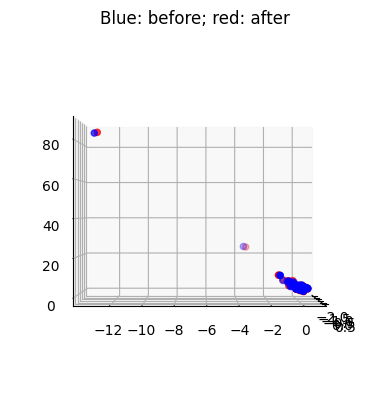

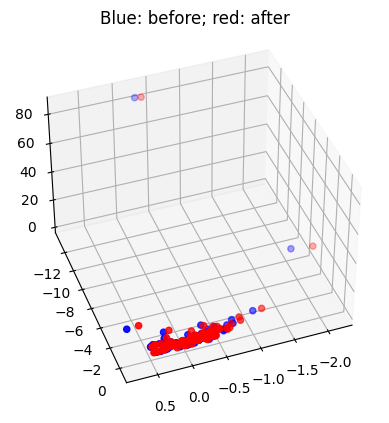

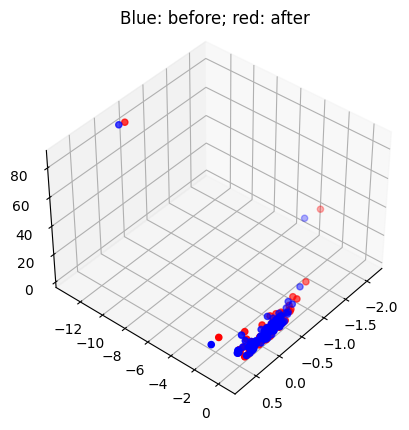

In [ ]:
# helper function for visualization
def plot_3D_dual(P_before, P_after, azim=70, elev=45):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("Blue: before; red: after")
    ax.scatter(P_before[:,0], P_before[:,1], P_before[:,2], c = 'blue')
    ax.scatter(P_after[:,0], P_after[:,1], P_after[:,2], c='red')
    ax.view_init(azim=azim, elev=elev)
    plt.draw()

# plots the 3d points before and after BA from different viewpoints
plot_3D_dual(P_init, P_final, azim=0, elev=0)
plot_3D_dual(P_init, P_final, azim=70, elev=40)
plot_3D_dual(P_init, P_final, azim=40, elev=40)

# (Extra Credit) Problem 6: Multiview Keypoint Reconstruction

## 6 Multi-View Reconstruction of keypoints

In [28]:
def MultiviewReconstruction(C1, pts1, C2, pts2, C3, pts3, Thres = 100):
  '''
  Q6.1 Multi-View Reconstruction of keypoints.
      Input:  C1, the 3x4 camera matrix
              pts1, the Nx3 matrix with the 2D image coordinates and confidence per row
              C2, the 3x4 camera matrix
              pts2, the Nx3 matrix with the 2D image coordinates and confidence per row
              C3, the 3x4 camera matrix
              pts3, the Nx3 matrix with the 2D image coordinates and confidence per row
      Output: P, the Nx3 matrix with the corresponding 3D points for each keypoint per row
              err, the reprojection error.
  '''

  # Replace pass with your implementation
  # ------- TODO -------
  # YOUR CODE HERE
  valid_pts1 = pts1[pts1[:, 2] > Thres, :2]
  valid_pts2 = pts2[pts2[:, 2] > Thres, :2]
  valid_pts3 = pts3[pts3[:, 2] > Thres, :2]

  num_points = valid_pts1.shape[0]
  P = np.zeros((num_points, 3))
  total_error = 0

  for i in range(num_points):
      confidences = [pts1[i, 2], pts2[i, 2], pts3[i, 2]]
      views = [valid_pts1, valid_pts2, valid_pts3]
      cameras = [C1, C2, C3]

      idx_best_views = np.argsort(confidences)[-2:]
      pts1_selected = views[idx_best_views[0]][i:i+1, :]

      P[i, :], error = triangulate(cameras[idx_best_views[0]], pts1_selected,
                                   cameras[idx_best_views[1]], views[idx_best_views[1]][i:i+1, :])
      total_error += error

  err = total_error / num_points

  return P, err
  # END YOUR CODE


### Plot Spatio-temporal (3D) keypoints


In [29]:
def plot_3d_keypoint_video(pts_3d_video):
  '''
  Plot Spatio-temporal (3D) keypoints
      :param car_points: np.array points * 3
  '''

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  for pts_3d in pts_3d_video:
      num_points = pts_3d.shape[1]
      for j in range(len(connections_3d)):
          index0, index1 = connections_3d[j]
          xline = [pts_3d[index0,0], pts_3d[index1,0]]
          yline = [pts_3d[index0,1], pts_3d[index1,1]]
          zline = [pts_3d[index0,2], pts_3d[index1,2]]
          ax.plot(xline, yline, zline, color=colors[j])
  np.set_printoptions(threshold=1e6, suppress=True)
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')
  plt.show()


Put it all together for all 10 timesteps.

In [30]:
pts_3d_video = []
for loop in range(10):
  print(f"processing time frame - {loop}")

  data_path = os.path.join('data/q6/','time'+str(loop)+'.npz')
  image1_path = os.path.join('data/q6/','cam1_time'+str(loop)+'.jpg')
  image2_path = os.path.join('data/q6/','cam2_time'+str(loop)+'.jpg')
  image3_path = os.path.join('data/q6/','cam3_time'+str(loop)+'.jpg')

  im1 = plt.imread(image1_path)
  im2 = plt.imread(image2_path)
  im3 = plt.imread(image3_path)

  data = np.load(data_path)
  pts1 = data['pts1']
  pts2 = data['pts2']
  pts3 = data['pts3']

  K1 = data['K1']
  K2 = data['K2']
  K3 = data['K3']

  M1 = data['M1']
  M2 = data['M2']
  M3 = data['M3']

  if loop == 0 or loop==9:  # feel free to modify to visualize keypoints at other loop timesteps
    img = visualize_keypoints(im2, pts2)

  # YOUR CODE HERE
  C1 = np.dot(K1, M1)  # Assuming intrinsic and extrinsic parameters are given
  C2 = np.dot(K2, M2)
  C3 = np.dot(K3, M3)

  pts_3d, err = MultiviewReconstruction(C1, pts1, C2, pts2, C3, pts3, Thres=100)
  pts_3d_video.append(pts_3d)

  # END YOUR CODE

  if loop == 0:
    plot_3d_keypoint(pts_3d)

plot_3d_keypoint_video(pts_3d_video)